In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pickle

from counterfactualgp.bsplines import BSplines
from counterfactualgp.lmm import LinearMixedModel, learn_lmm

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
n_train = data['n_train']
low, high = data['xlim']
num_basis = 5
bsplines_degree = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')

In [4]:
def draw_lmm_prediction(lmm, samples_star, samples_test, 
                        nrow=3, ncol=3, title=None,
                        samples_test_no_rx=None,
                        truncated_time=None):
    beta, Sigma, v = lmm.param_copy()

    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12,8), sharex=True, sharey=True)
    if not samples_test_no_rx:
        samples_test_no_rx = [None] * len(samples_test)
    for idx, (ss, st, stnx) in enumerate(zip(samples_star, samples_test, samples_test_no_rx)):
        if idx == nrow*ncol: break
        r = idx // nrow
        c = idx % nrow
            
        y,x,z = ss
        yt,tt = st
        if stnx: ytnx,ttnx = stnx
        
        m, S = lmm.posterior(y,x,z)
        
        tp = np.linspace(low, high, num=100)
        yhat = np.dot(basis.design(tp), m) + np.dot(basis.design(tp), beta)

        axes[r,c].plot(tp, yhat)
        axes[r,c].scatter(tt, yt)
        if stnx: 
            axes[r,c].scatter(ttnx, ytnx+0.1*np.random.random(ytnx.shape), color='orange')
        if truncated_time:
            axes[r,c].axvline(x=truncated_time, color='r', ls='--')
            
    if title: plt.suptitle(title)
    plt.show()

In [5]:
samples = [(y,basis.design(x),basis.design(x)) for y,x in data['samples'][:n_train]]
lmm = learn_lmm(samples)

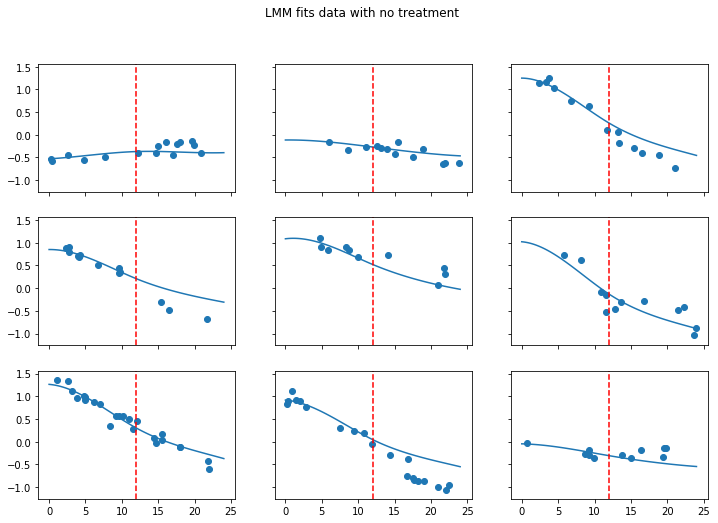

In [6]:
truc = data['truncated_time']
samples_star = [(y[x<truc], basis.design(x)[x<truc], basis.design(x)[x<truc]) 
                for y,x in data['samples'][n_train:]]
samples_test = [(y,x) for y,x in data['samples'][n_train:]]

draw_lmm_prediction(lmm, samples_star, samples_test, 3, 3, 'LMM fits data with no treatment', None, truc)

In [7]:
samples_rx = [(y, basis.design(x), basis.design(x)) for y,(x,_) in data['training2']]
lmm_rx = learn_lmm(samples_rx)

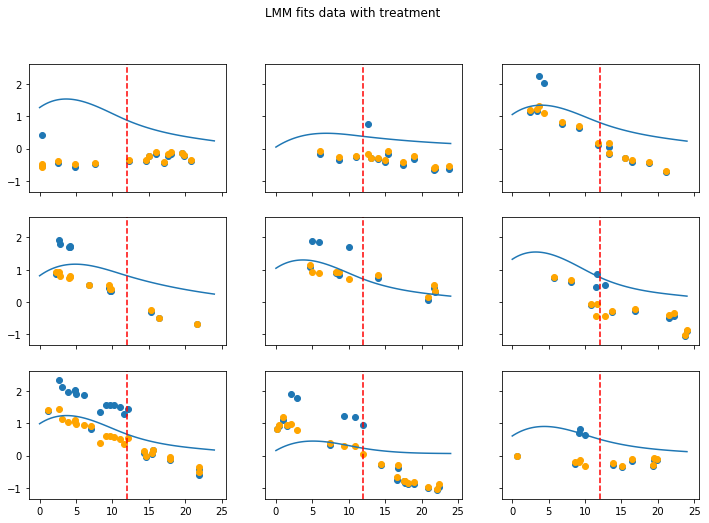

In [8]:
truc = data['truncated_time']
samples_rx_star = [(y[x<truc], basis.design(x)[x<truc], basis.design(x)[x<truc]) 
                for y,(x,_) in data['training2']]
samples_rx_test = [(y,x) for y,(x,_) in data['testing2']]

draw_lmm_prediction(lmm_rx, samples_rx_star, samples_rx_test, 3, 3, 'LMM fits data with treatment', samples_test, truc)